# Run MobileNet on a Camera 

* [ssdlite320_mobilenet_v3_large](https://pytorch.org/vision/stable/models/generated/torchvision.models.detection.ssdlite320_mobilenet_v3_large.html)
* [Real Time Inference on Raspberry Pi 4](https://pytorch.org/tutorials/intermediate/realtime_rpi.html)



In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
if ".." not in sys.path:
    sys.path.append("..")  # Append pieye module root to sys.path

import cv2
import numpy as np
from picamera2 import Picamera2, Preview
from PIL import Image
# import torch
# from torchvision import models, transforms

# from pieye.video import play
from pieye.utils import show_bboxes


# Note, The aarch64 version of pytorch requires using the `qnnpack` engine.
# torch.backends.quantized.engine = "qnnpack"
# torch.set_num_threads(2)

# print(f"torch {torch.__version__}")

In [3]:
cam = Picamera2()
config = cam.create_preview_configuration()
cam.configure(config)
# cam.configure(cam.create_preview_configuration(main={"format": 'XRGB8888', "size": (640, 480)}))

[0:12:00.954526338] [2298]  INFO Camera camera_manager.cpp:316 libcamera v0.3.1+50-69a894c4
[0:12:00.995317125] [2325]  WARN RPiSdn sdn.cpp:40 Using legacy SDN tuning - please consider moving SDN inside rpi.denoise
[0:12:00.997247491] [2325]  INFO RPI vc4.cpp:447 Registered camera /base/soc/i2c0mux/i2c@1/imx708@1a to Unicam device /dev/media3 and ISP device /dev/media1
[0:12:00.997301398] [2325]  INFO RPI pipeline_base.cpp:1125 Using configuration file '/usr/share/libcamera/pipeline/rpi/vc4/rpi_apps.yaml'
[0:12:01.006064529] [2298]  INFO Camera camera.cpp:1191 configuring streams: (0) 640x480-XBGR8888 (1) 1536x864-SBGGR10_CSI2P
[0:12:01.006485435] [2325]  INFO RPI vc4.cpp:622 Sensor: /base/soc/i2c0mux/i2c@1/imx708@1a - Selected sensor format: 1536x864-SBGGR10_1X10 - Selected unicam format: 1536x864-pBAA


In [4]:
cam.start_preview()

In [ ]:
cam.start()

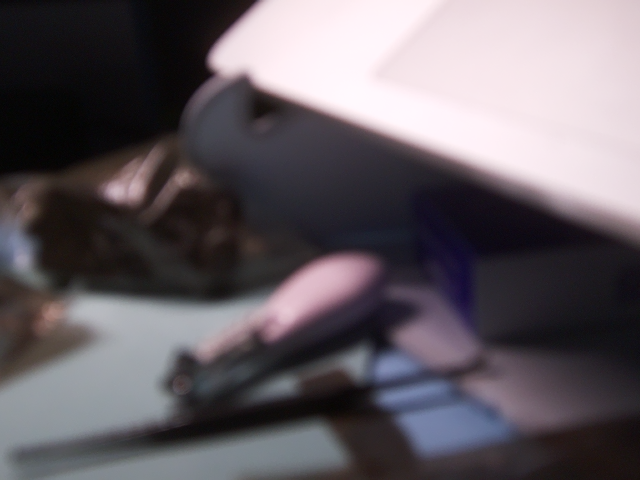

In [11]:
Image.fromarray(cam.capture_array())

In [12]:
cam.stop()

In [9]:
import threading
from time import sleep

class VideoCapture(threading.Thread):
    def __init__(self, cap):
        super().__init__()
        self.cap = cap
        self.frame = None
        self.capture = False
    
    def run(self):
        try:
            while self.capture:
                _, self.frame = self.cap.read()
        finally:
            pass  # TODO: print log

    def start(self):
        self.capture = True
        super().start()
    
    def stop(self):
        self.capture = False
        self.frame = None
        self.join()

class Camera():
    def __init__(self, fps: int = 30):
        self.cap = cv2.VideoCapture(0)
        self.cap.set(cv2.CAP_PROP_FRAME_WIDTH, 320)  # ssdlite320_mobilenet_v3_large's input size is 320x320
        self.cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 320)
        self.cap.set(cv2.CAP_PROP_FPS, fps)
        self.video_capture = None
        
    def start(self):
        self.stop()
        self.video_capture = VideoCapture(self.cap)
        self.video_capture.start()
        sleep(1)  # delay for starting the cam

    def stop(self):
        if self.video_capture is not None:
            self.video_capture.stop()
            self.video_capture = None

    def get_frame(self):
        if self.video_capture is not None:
            return self.video_capture.frame
        else:
            return None

    def release(self):
        self.stop()
        self.cap.release()

    # def __enter__(self)
    # def __exit__(self, exc_type, exc_value, traceback)

In [7]:
cam = Camera(fps=10)
cam.start()

In [10]:
type(cam.get_frame())

NoneType

[ WARN:1@69.167] global cap_v4l.cpp:1136 tryIoctl VIDEOIO(V4L2:/dev/video0): select() timeout.
[ WARN:1@79.175] global cap_v4l.cpp:1136 tryIoctl VIDEOIO(V4L2:/dev/video0): select() timeout.
[ WARN:1@89.177] global cap_v4l.cpp:1136 tryIoctl VIDEOIO(V4L2:/dev/video0): select() timeout.
[ WARN:1@99.187] global cap_v4l.cpp:1136 tryIoctl VIDEOIO(V4L2:/dev/video0): select() timeout.
[ WARN:1@109.197] global cap_v4l.cpp:1136 tryIoctl VIDEOIO(V4L2:/dev/video0): select() timeout.
[ WARN:1@119.208] global cap_v4l.cpp:1136 tryIoctl VIDEOIO(V4L2:/dev/video0): select() timeout.
[ WARN:1@129.218] global cap_v4l.cpp:1136 tryIoctl VIDEOIO(V4L2:/dev/video0): select() timeout.
[ WARN:1@139.226] global cap_v4l.cpp:1136 tryIoctl VIDEOIO(V4L2:/dev/video0): select() timeout.
[ WARN:1@149.237] global cap_v4l.cpp:1136 tryIoctl VIDEOIO(V4L2:/dev/video0): select() timeout.
[ WARN:1@159.248] global cap_v4l.cpp:1136 tryIoctl VIDEOIO(V4L2:/dev/video0): select() timeout.
[ WARN:1@169.258] global cap_v4l.cpp:1136 tr

In [8]:
image = Image.fromarray(cam.get_frame()[:, :, [2, 1, 0]])
image

TypeError: 'NoneType' object is not subscriptable

[ WARN:1@39.136] global cap_v4l.cpp:1136 tryIoctl VIDEOIO(V4L2:/dev/video0): select() timeout.
[ WARN:1@49.146] global cap_v4l.cpp:1136 tryIoctl VIDEOIO(V4L2:/dev/video0): select() timeout.


In [6]:
cam.release()

[ WARN:0@25.006] global cap_v4l.cpp:1136 tryIoctl VIDEOIO(V4L2:/dev/video0): select() timeout.


In [31]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # normalize the colors to the range that mobilenet_v2/3 expect
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [33]:
# Quantized (int8) model
# Quantized MobileNetV3-Large is about the same speed and size as MobileNetv3-Small, but it has higher accuracy.
model = models.quantization.mobilenet_v3_large(pretrained=True, quantize=True)

# Convert into jit (graph mode). In eager mode, operators in a model are immediately executed as they are encountered. In contrast, in graph mode, operators are first synthesized into a graph, which will then be compiled and executed as a whole
# This reduce overhead
model = torch.jit.script(model)

# Let batchnorm or dropout layers work in eval mode instead of training mode.
model = model.eval()

/home/junkimin/env/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/junkimin/env/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_QuantizedWeights.IMAGENET1K_QNNPACK_V1`. You can also use `weights=MobileNet_V3_Large_QuantizedWeights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/junkimin/env/torch/lib/python3.11/site-packages/torch/ao/quantization/utils.py:376: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(


In [34]:
input_tensor = preprocess(image)
# The model can handle multiple images simultaneously so we need to add an
# empty dimension for the batch.
# [320, 320, 3] -> [1, 3, 320, 320]
input_batch = input_tensor.unsqueeze(0)
input_batch.shape

torch.Size([1, 3, 224, 224])

In [35]:
# deactivate autograd engine to not backprop
with torch.no_grad():
    output = model(input_batch)

In [36]:
output.shape

torch.Size([1, 1000])

In [42]:
with open("imagenet_class_labels.txt") as f:
    idx_to_label = eval(f.read())

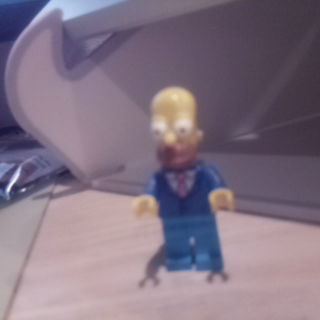

15.60% airship, dirigible
15.60% toilet tissue, toilet paper, bathroom tissue
8.96% dishwasher, dish washer, dishwashing machine
8.96% mousetrap
7.45% balloon
2.96% ballpoint, ballpoint pen, ballpen, Biro
2.96% knee pad
2.96% swab, swob, mop
2.05% printer
2.05% volleyball


In [43]:
display(image)

top = list(enumerate(output[0].softmax(dim=0)))
top.sort(key=lambda x: x[1], reverse=True)
for idx, val in top[:10]:
    print(f"{val.item()*100:.2f}% {idx_to_label[idx]}")

### Object Detection

In [18]:
detection_threshold = 0.5

In [19]:
preprocess_no_normalize = transforms.Compose([
    # convert the frame to a CHW torch tensor for training
    transforms.ToTensor(),
])

In [20]:
# Load object detection model. TODO: Need to quantize manually
model = models.detection.ssdlite320_mobilenet_v3_large(pretrained=True)
model = model.eval()

/home/junkimin/env/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSDLite320_MobileNet_V3_Large_Weights.COCO_V1`. You can also use `weights=SSDLite320_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/ssdlite320_mobilenet_v3_large_coco-a79551df.pth" to /home/junkimin/.cache/torch/hub/checkpoints/ssdlite320_mobilenet_v3_large_coco-a79551df.pth
100.0%


In [21]:
input_tensor = preprocess_no_normalize(image)
input_batch = input_tensor.unsqueeze(0)

with torch.no_grad():
    outputs = model(input_batch)

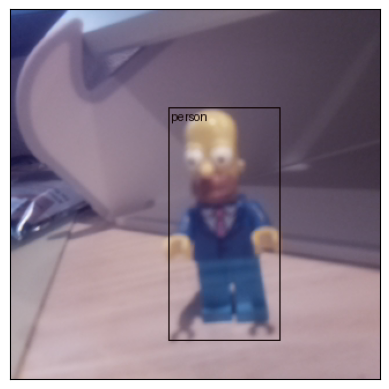

In [30]:
show_bboxes(image=input_tensor, outputs=outputs)